In [1]:
from collections import defaultdict
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle

In [2]:
train = pd.read_csv('dataset/train.csv')
valid = pd.read_csv('dataset/valid.csv')
test = pd.read_csv('dataset/test.csv')


train = train.astype({'userId': 'str','movieId': 'str'})
valid = valid.astype({'userId': 'str','movieId': 'str'})
test = test.astype({'userId': 'str','movieId': 'str'})

X_train = train[['userId','movieId','rating']].values
X_val = valid[['userId','movieId','rating']].values
X_test = test[['userId','movieId','rating']].values

print('Training Size: %d' % len(X_train))
print('Validation Size: %d' % len(X_val))
print('Testing Size: %d' % len(X_test))

Training Size: 70399
Validation Size: 8800
Testing Size: 8800


In [3]:
usersPerMovie = defaultdict(set)
moviesPerUser = defaultdict(set)
usersPerMovie_rate = defaultdict(list)
moviesPerUser_rate = defaultdict(list)
usermovie_rating = defaultdict(int)

user_Map = defaultdict(int)
u_Count = 0
movie_Map = defaultdict(int)
m_Count = 0

alpha_init = 0

count = 0
for user, movie, r in X_train:
    usersPerMovie[movie].add(user)
    moviesPerUser[user].add(movie)
    usermovie_rating[user+movie] = r
    usersPerMovie_rate[movie].append((user,r))
    moviesPerUser_rate[user].append((movie,r))
    
    if user not in user_Map:
        user_Map[user] = u_Count
        u_Count += 1
    if movie not in movie_Map:
        movie_Map[movie] = m_Count
        m_Count += 1
    
    alpha_init += r
alpha_init /= len(X_train)  
print('alpha_init_avg - %f' % alpha_init)

alpha_init_avg - 3.546187


### Simple Model

In [4]:
def model_initial(alpha_init, mode = 'normal'):
    '''
    Initialize parameters of betas
    
    Returns: beta_user(dict): how often this user tends to rate higher than mean
             beta_movie(dict): how often this movie is rated higher than mean
             mode(str): choose mode to generate initialization
    '''
    if mode == 'normal':
        beta_user = {}
        beta_movie = {}
        for u in moviesPerUser:
            count_high = 0
            count = 0
            for m in moviesPerUser_rate[u]:
                count+=1
                if m[1]>alpha_init:
                    count_high += 1
                else:
                    count_high -= 1

            beta_user[u] = float(count_high)/count

        for m in usersPerMovie:
            count_high = 0
            count = 0
            for u in usersPerMovie_rate[m]:
                count+=1
                if u[1]>alpha_init:
                    count_high += 1
                else:
                    count_high -= 1

            beta_movie[m] = float(count_high)/count

        return beta_user, beta_movie
    
    elif mode == 'random':
        mu, sigma = 0, 0.1 
        
        beta_user = {}
        beta_movie = {}
        for u in moviesPerUser:
            beta_user[u] = np.random.normal(mu, sigma, 1)

        for m in usersPerMovie:
            beta_movie[m] = np.random.normal(mu, sigma, 1)

        return beta_user, beta_movie

In [5]:
def evaluate(alpha, beta_user, beta_movie, data = 'valid', user_Map = None, movie_Map = None, ga_u = None
             , ga_m = None,  latent_factor = False):
    '''
    Evaluate the model
    
    Returns: alpha(float): global mean
             beta_user(dict): how often this user tends to rate higher than mean
             beta_movie(dict): how often this movie is rated higher than mean
             data(str): choose the dataset to be evaluated
             user_Map, movie_Map(dict): map the index of gamma matrix
             ga_u, ga_m(np.array): gamma matrix
             latent_factor(bool): whether latent factor model is considered
    '''
 
    pred_rate = []
    error = 0
    if data == 'valid':
        eval_set = X_val
    elif data == 'test':
        eval_set = X_test

    for u_v, m_v, r_v in eval_set:
        beta_u, beta_m = beta_user.get(u_v, 0), beta_movie.get(m_v, 0)
        pred = alpha + beta_u + beta_m
        if latent_factor == True:
            if u_v in user_Map and m_v in movie_Map:
                pred += np.inner(ga_u[user_Map[u_v]], ga__m[movie_Map[m_v]])

        if pred>5:
            pred = 5
        elif pred<0:
            pred = 0

        pred_rate.append(pred)
        error += (r_v - pred) ** 2
    return error/ len(pred_rate)


In [6]:
alpha = 0
lamb_list = [i for i in range(1, 6)]

n_epoch = 500
thres = 1* 10**-2

MSE_final = []
for lamb in lamb_list:
    print('--------- lambda = %d ----------' % lamb)
    
    old_MSE, MSE = 0, 0

    beta_user, beta_movie = model_initial(alpha_init, mode = 'normal')
    
    for ite in range(n_epoch):

        # update alpha
        tmp_alpha = 0
        for user, movie, rating in X_train:
            tmp_alpha += (rating - ( beta_user[user] + beta_movie[movie] ))
        alpha = tmp_alpha / len(X_train)

        # update beta_user
        tmp_beta_user = {}
        for u in beta_user:
            temp = sum([usermovie_rating[u+m] - (alpha+beta_movie[m]) for m in moviesPerUser[u]])
            tmp_beta_user[u] = temp/ (lamb + len(moviesPerUser[u]))

        # update beta movie
        tmp_beta_movie = {}
        for m in beta_movie:
            temp = sum([usermovie_rating[u+m] - (alpha+beta_user[u]) for u in usersPerMovie[m]])
            tmp_beta_movie[m] = temp/ (lamb + len(usersPerMovie[m]))

        for u in beta_user:
            beta_user[u] = tmp_beta_user[u]
        for m in beta_movie:
            beta_movie[m] = tmp_beta_movie[m]

        # calculate MSE(validation set)
        MSE = evaluate(alpha, beta_user, beta_movie, data = 'valid')

        if ite%100 == 1: 
            print('Iter: %d - -  Alpha = %f, MSE = %f' % (ite, alpha, MSE))

        if ite>=1 and (MSE-old_MSE)>thres:
            print('Early Stop at Epoch %d' % ite)         
            break

        old_MSE = MSE
    
    MSE_final.append(MSE)

    
    # calculate MSE(testing set)
    MSE_t = evaluate(alpha, beta_user, beta_movie, data = 'test')
    print('Testing MSE = %f' % (MSE_t))

--------- lambda = 1 ----------
Iter: 1 - -  Alpha = 3.461597, MSE = 0.789621
Iter: 101 - -  Alpha = 3.435965, MSE = 0.786265
Iter: 201 - -  Alpha = 3.468941, MSE = 0.786237
Iter: 301 - -  Alpha = 3.482010, MSE = 0.786226
Iter: 401 - -  Alpha = 3.487160, MSE = 0.786222
Testing MSE = 0.750562
--------- lambda = 2 ----------
Iter: 1 - -  Alpha = 3.457988, MSE = 0.784928
Iter: 101 - -  Alpha = 3.462732, MSE = 0.781828
Iter: 201 - -  Alpha = 3.479517, MSE = 0.781804
Iter: 301 - -  Alpha = 3.482229, MSE = 0.781800
Iter: 401 - -  Alpha = 3.482667, MSE = 0.781799
Testing MSE = 0.747240
--------- lambda = 3 ----------
Iter: 1 - -  Alpha = 3.455832, MSE = 0.784309
Iter: 101 - -  Alpha = 3.475697, MSE = 0.781614
Iter: 201 - -  Alpha = 3.483245, MSE = 0.781598
Iter: 301 - -  Alpha = 3.483762, MSE = 0.781597
Iter: 401 - -  Alpha = 3.483798, MSE = 0.781597
Testing MSE = 0.747680
--------- lambda = 4 ----------
Iter: 1 - -  Alpha = 3.454483, MSE = 0.785089
Iter: 101 - -  Alpha = 3.483068, MSE = 0.78

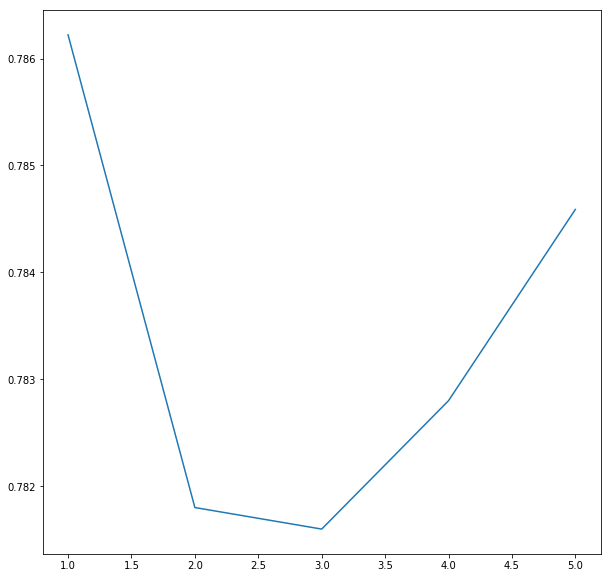

In [7]:
plt.figure(figsize=(10,10))
plt.plot([i for i in range(1, 6)],MSE_final)

In [8]:
alpha = 0
lamb_list = [i for i in np.arange(2.5, 3.6, 0.1)]
alpha_f = 0
beta_user_f = {}
beta_movie_f = {}

n_epoch = 500
thres = 1* 10**-2

MSE_final = []
for lamb in lamb_list:
    print('--------- lambda = %.2f ----------' % lamb)

    old_MSE, MSE = 0, 0
    beta_user, beta_movie = model_initial(alpha_init, mode = 'normal')
    
    for ite in range(n_epoch):

        # update alpha
        tmp_alpha = 0
        for user, movie, rating in X_train:
            tmp_alpha += (rating - ( beta_user[user] + beta_movie[movie] ))
        alpha = tmp_alpha / len(X_train)

        # update beta_user
        tmp_beta_user = {}
        for u in beta_user:
            temp = sum([usermovie_rating[u+m] - (alpha+beta_movie[m]) for m in moviesPerUser[u]])
            tmp_beta_user[u] = temp/ (lamb + len(moviesPerUser[u]))

        # update beta movie
        tmp_beta_movie = {}
        for m in beta_movie:
            temp = sum([usermovie_rating[u+m] - (alpha+beta_user[u]) for u in usersPerMovie[m]])
            tmp_beta_movie[m] = temp/ (lamb + len(usersPerMovie[m]))

        for u in beta_user:
            beta_user[u] = tmp_beta_user[u]
        for m in beta_movie:
            beta_movie[m] = tmp_beta_movie[m]

        # calculate MSE(validation set)
        MSE = evaluate(alpha, beta_user, beta_movie, 'valid')
        if ite%100 == 1: 
            print('Iter: %d - -  Alpha = %f, MSE = %f' % (ite, alpha, MSE))

        if ite>=1 and (MSE-old_MSE)>thres:         
            print('Early Stop at Epoch %d' % ite)
            break

        old_MSE = MSE
    MSE_final.append(MSE) 

    # calculate MSE(testing set)
    MSE_t = evaluate(alpha, beta_user, beta_movie, data = 'test')
    print('Testing MSE = %f' % (MSE_t))

--------- lambda = 2.50 ----------
Iter: 1 - -  Alpha = 3.456782, MSE = 0.784356
Iter: 101 - -  Alpha = 3.470259, MSE = 0.781453
Iter: 201 - -  Alpha = 3.481573, MSE = 0.781433
Iter: 301 - -  Alpha = 3.482759, MSE = 0.781431
Iter: 401 - -  Alpha = 3.482883, MSE = 0.781431
Testing MSE = 0.747226
--------- lambda = 2.60 ----------
Iter: 1 - -  Alpha = 3.456574, MSE = 0.784312
Iter: 101 - -  Alpha = 3.471484, MSE = 0.781451
Iter: 201 - -  Alpha = 3.481924, MSE = 0.781432
Iter: 301 - -  Alpha = 3.482928, MSE = 0.781430
Iter: 401 - -  Alpha = 3.483025, MSE = 0.781430
Testing MSE = 0.747288
--------- lambda = 2.70 ----------
Iter: 1 - -  Alpha = 3.456375, MSE = 0.784288
Iter: 101 - -  Alpha = 3.472634, MSE = 0.781467
Iter: 201 - -  Alpha = 3.482264, MSE = 0.781449
Iter: 301 - -  Alpha = 3.483114, MSE = 0.781448
Iter: 401 - -  Alpha = 3.483190, MSE = 0.781448
Testing MSE = 0.747365
--------- lambda = 2.80 ----------
Iter: 1 - -  Alpha = 3.456186, MSE = 0.784280
Iter: 101 - -  Alpha = 3.473715

Optimized Lambda: 2.60


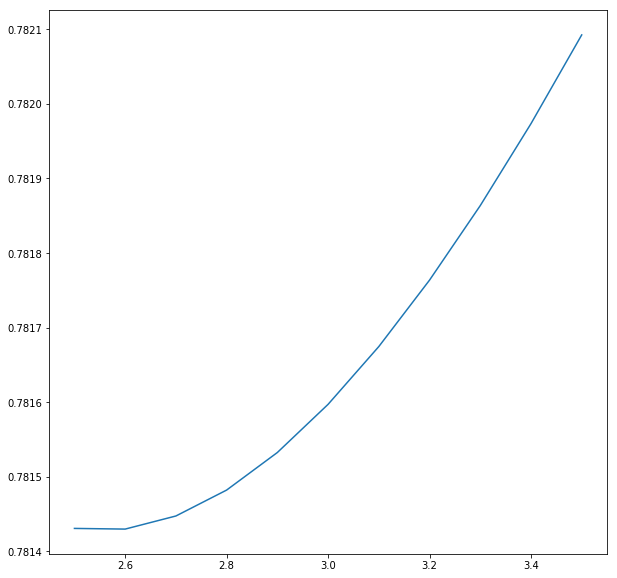

In [10]:
idx = np.argmin(MSE_final)
optimized_lamb = lamb_list[idx]
print('Optimized Lambda: %.2f' % optimized_lamb)
plt.figure(figsize=(10,10))
plt.plot( lamb_list, MSE_final)

In [11]:
f = open('dataset/rating_model.pkl', 'wb')
pickle.dump([alpha,beta_user, beta_movie], f)
f.close()

In [12]:
f = open('dataset/rating_model.pkl', 'rb')
obj = pickle.load(f)
f.close()

In [ ]:
alpha_d, beta_user_d, beta_movie_d = obj
def predict(user, movie):
    '''
    Predict how much the user would rate on the movie
    
    Returns: user(str), movie(str)
    '''
    beta_u, beta_m = beta_user_d.get(user, 0), beta_movie_d.get(movie, 0)
    pred_rating = alpha_d + beta_u + beta_m

    if pred_rating>5:
        pred_rating = 5
    elif pred_rating<0:
        pred_rating = 0

    return pred_rating